In [1]:
# ! pip install wandb
! pip install dm-haiku

In [2]:
import tensorflow as tf

tf.config.experimental.set_visible_devices([], 'GPU')
tf.config.experimental.set_visible_devices([], 'TPU_SYSTEM')
tf.config.experimental.set_visible_devices([], 'TPU')

print(tf.config.experimental.get_visible_devices())

import uncertainty_baselines as ub

import wandb
import pathlib
from datetime import datetime

import flax.jax_utils as flax_utils
from functools import partial  # pylint: disable=g-importing-member so standard
import itertools
import multiprocessing
import numbers
import os

from absl import app
from absl import flags
from absl import logging
from clu import metric_writers
from clu import parameter_overview
from clu import periodic_actions
from clu import preprocess_spec
import flax
import flax.jax_utils as flax_utils
import jax
import jax.numpy as jnp
import numpy as np
import robustness_metrics as rm

import tensorflow as tf
from tensorflow.io import gfile
import checkpoint_utils  # local file import
import input_utils  # local file import
import train_utils  # local file import
import preprocess_utils  # local file import
# local file import
from imagenet21k_vit_base16_finetune_country_shift import get_config

2021-12-22 03:11:19.682904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-22 03:11:19.682940: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2021-12-22 03:11:21.881897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-22 03:11:21.881945: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-22 03:11:21.881967: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t1v-n-9dd13ff2-w-0): /proc/driver/nvidia/version does not exist


In [3]:
output_dir = 'tmp/diabetic_retinopathy_detection/vit-16-i21k'
tf.io.gfile.makedirs(output_dir)
logging.info('Saving checkpoints at %s', output_dir)

In [4]:
from vit16_deterministic import accumulate_gradient_with_states

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
print('Number of Jax local devices:', jax.local_devices())

Number of Jax local devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [6]:
config = get_config()

In [7]:
seed = 0
rng = jax.random.PRNGKey(seed)
tf.random.set_seed(seed)

In [8]:
if config.get('data_dir'):
    logging.info('data_dir=%s', config.data_dir)
logging.info('Output dir: %s', output_dir)

save_checkpoint_path = None
if config.get('checkpoint_steps'):
    gfile.makedirs(output_dir)
    save_checkpoint_path = os.path.join(output_dir, 'checkpoint.npz')
    
# Create an asynchronous multi-metric writer.
writer = metric_writers.create_default_writer(
    output_dir, just_logging=jax.process_index() > 0)

# The pool is used to perform misc operations such as logging in async way.
pool = multiprocessing.pool.ThreadPool()

def write_note(note):
    if jax.host_id() == 0:
        logging.info('NOTE: %s', note)
write_note('Initializing...')

fillin = lambda *_: None
# Verify settings to make sure no checkpoints are accidentally missed.
if config.get('keep_checkpoint_steps'):
    assert config.get('checkpoint_steps'), 'Specify `checkpoint_steps`.'
    assert config.keep_checkpoint_steps % config.checkpoint_steps == 0, (
        f'`keep_checkpoint_steps` ({config.checkpoint_steps}) should be'
        f'divisible by `checkpoint_steps ({config.checkpoint_steps}).`')
    
batch_size = config.batch_size
batch_size_eval = config.get('batch_size_eval', batch_size)
if (batch_size % jax.device_count() != 0 or
      batch_size_eval % jax.device_count() != 0):
    raise ValueError(f'Batch sizes ({batch_size} and {batch_size_eval}) must '
         f'be divisible by device number ({jax.device_count()})')

2021-12-22 03:11:38.156776: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nband/ub_venv/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:412: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


In [9]:
local_batch_size = batch_size // jax.host_count()
local_batch_size_eval = batch_size_eval // jax.host_count()
logging.info(
  'Global batch size %d on %d hosts results in %d local batch size. '
  'With %d devices per host (%d devices total), that\'s a %d per-device '
  'batch size.',
  batch_size, jax.host_count(), local_batch_size,
  jax.local_device_count(), jax.device_count(),
  local_batch_size // jax.local_device_count())

write_note('Initializing train dataset...')
rng, train_ds_rng = jax.random.split(rng)
train_ds_rng = jax.random.fold_in(train_ds_rng, jax.process_index())
print(train_ds_rng)

train_base_dataset = ub.datasets.get(
    config.in_domain_dataset, split=config.train_split,
    data_dir=config.get('data_dir'))
train_dataset_builder = train_base_dataset._dataset_builder

# Same for training and evaluation
preproc_fn = preprocess_spec.parse(
    spec=config.pp_train, available_ops=preprocess_utils.all_ops())

train_ds = input_utils.get_data(
    # dataset=config.in_domain_dataset,
    dataset=train_dataset_builder,
    split=config.train_split,
    rng=train_ds_rng,
    host_batch_size=local_batch_size,
    preprocess_fn=preproc_fn,
    shuffle_buffer_size=config.shuffle_buffer_size,
    prefetch_size=config.get('prefetch_to_host', 2),
    data_dir=config.get('data_dir'))

# Start prefetching already.
train_iter = input_utils.start_input_pipeline(
    train_ds, config.get('prefetch_to_device', 1))

print(next(train_iter))

write_note('Initializing val dataset(s)...')

/home/nband/ub_venv/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:425: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(
Traceback (most recent call last):
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/datasets/datasets.py", line 57, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 'seqio'


[ 452556574 3005505313]


Traceback (most recent call last):
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/datasets/datasets.py", line 69, in <module>
    from uncertainty_baselines.datasets.speech_commands import SpeechCommandsDataset  # pylint: disable=g-import-not-at-top
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/datasets/speech_commands.py", line 29, in <module>
    import librosa
  File "/home/nband/ub_venv/lib/python3.8/site-packages/librosa/__init__.py", line 211, in <module>
    from . import core
  File "/home/nband/ub_venv/lib/python3.8/site-packages/librosa/core/__init__.py", line 6, in <module>
    from .audio import *  # pylint: disable=wildcard-import
  File "/home/nband/ub_venv/lib/python3.8/site-packages/librosa/core/audio.py", line 8, in <module>
    import soundfile as sf
  File "/home/nband/ub_venv/lib/python3.8/site-packages/soundfile.py", line 142, in <module>
    raise OSError('sndfile library not found')
OSError: sndfile library not found
Traceback (

Using UBDiabeticRetinopathyDetection builder config ub_diabetic_retinopathy_detection/btgraham-300.


Building Kaggle DR dataset with decision threshold: moderate.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
{'image': ShardedDeviceArray([[[[[0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608],
                       ...,
                       [0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608]],

                      [[0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608],
                       [0.5019608, 0.5019608, 0.5019608],
                       ...,
                       [0.5019608, 0.50

/home/nband/ub_venv/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:412: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(


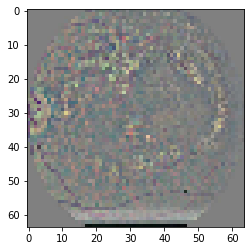

In [10]:
from matplotlib import pyplot as plt
plt.imshow(next(train_iter)['image'][0][0], interpolation='nearest')
plt.show()

In [11]:
  def _get_val_split(dataset,
                     split,
                     pp_eval,
                     data_dir=None):
    del pp_eval  # Same as pp_train for Diabetic Retinopathy.

    # We do ceil rounding such that we include the last incomplete batch.
    nval_img = input_utils.get_num_examples(
      dataset,
      split=split,
      host_batch_size=local_batch_size_eval,
      drop_remainder=False,
      data_dir=fillin(data_dir))
    val_steps = int(np.ceil(nval_img / batch_size_eval))
    logging.info('Running validation for %d steps for %s, %s', val_steps,
                 dataset, split)

    val_ds = input_utils.get_data(
      # dataset=config.in_domain_dataset,
      dataset=dataset,
      split=config.val_split,
      rng=None,
      host_batch_size=local_batch_size_eval,
      # preprocess_fn=preprocess_spec.parse(
      #   spec=pp_eval, available_ops=preprocess_utils.all_ops()),
      preprocess_fn=preproc_fn,
      # cache=config.get('val_cache', 'batched'),
      cache=False,
      repeat_after_batching=True,
      shuffle=False,
      prefetch_size=config.get('prefetch_to_host', 2),
      drop_remainder=False,
      data_dir=config.get('data_dir'))
    
    val_iter = input_utils.start_input_pipeline(
      val_ds, config.get('prefetch_to_device', 1))

    return (val_iter, val_steps)

In [12]:
val_base_dataset = ub.datasets.get(
    config.in_domain_dataset, split=config.val_split,
    data_dir=config.get('data_dir'))
val_dataset_builder = val_base_dataset._dataset_builder
# val_preproc_fn = train_base_dataset._create_process_example_fn()
val_iter_splits = {
    'val': _get_val_split(
        # config.in_domain_dataset,
        val_dataset_builder,
        config.val_split,
        pp_eval=config.pp_eval,
        data_dir=config.get('data_dir'))
}

Using UBDiabeticRetinopathyDetection builder config ub_diabetic_retinopathy_detection/btgraham-300.


Building Kaggle DR dataset with decision threshold: moderate.


In [13]:
ntrain_img = input_utils.get_num_examples(
      # config.dataset,
      # config.in_domain_dataset,
      train_dataset_builder,
      split=config.train_split,
      host_batch_size=local_batch_size,
      # data_dir=fillin(config.get('data_dir')))
      data_dir=config.get('data_dir'))

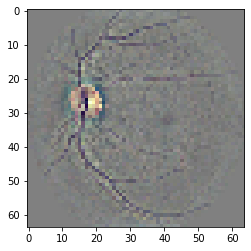

In [14]:
plt.imshow(next(val_iter_splits['val'][0])['image'][0][0], interpolation='nearest')
plt.show()

In [15]:
 steps_per_epoch = ntrain_img / batch_size
if config.get('num_epochs'):
    total_steps = int(config.num_epochs * steps_per_epoch)
    assert not config.get('total_steps'), 'Set either num_epochs or total_steps'
else:
    total_steps = config.total_steps

In [16]:
logging.info(
    'Running for %d steps, that means %f epochs and %f steps per epoch',
    total_steps, total_steps * batch_size / ntrain_img, steps_per_epoch)

write_note('Initializing model...')
logging.info('config.model = %s', config.get('model'))
model = ub.models.vision_transformer(
    num_classes=config.num_classes, **config.get('model', {}))

/home/nband/ub_venv/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:412: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  warnings.warn(
Traceback (most recent call last):
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/models/models.py", line 36, in <module>
    from uncertainty_baselines.models.bert import bert_model  # pylint: disable=g-import-not-at-top
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/models/bert.py", line 29, in <module>
    from official.nlp import optimization
ModuleNotFoundError: No module named 'official'
Traceback (most recent call last):
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/models/__init__.py", line 86, in <module>
    from uncertainty_baselines.models import bert
  File "/home/nband/uncertainty-baselines/uncertainty_baselines/models/bert.py", line 29, in <module>
    from official.nlp import optimization
ModuleNot

In [17]:
# We want all parameters to be created in host RAM, not on any device, they'll
# be sent there later as needed, otherwise we already encountered two
# situations where we allocate them twice.
@partial(jax.jit, backend='cpu')
def init(rng):
    # print(train_ds.element_spec['image'].shape)
    image_size = tuple(train_ds.element_spec['image'].shape[2:])
    # image_size = tuple(train_ds.element_spec['image'])
#     image_size = (config.pp_input_res, config.pp_input_res, 3)
    # print(image_size)
    # image_size = tuple(train_ds.element_spec['features'].shape[2:])
    logging.info('image_size = %s', image_size)
    dummy_input = jnp.zeros((local_batch_size,) + image_size, jnp.float32)
    params = flax.core.unfreeze(model.init(rng, dummy_input,
                                           train=False))['params']

    # Set bias in the head to a low value, such that loss is small initially.
    params['head']['bias'] = jnp.full_like(
      params['head']['bias'], config.get('init_head_bias', 0))

    # init head kernel to all zeros for fine-tuning
    if config.get('model_init'):
        params['head']['kernel'] = jnp.full_like(params['head']['kernel'], 0)

    return params

rng, rng_init = jax.random.split(rng)
params_cpu = init(rng_init)

if jax.host_id() == 0:
    num_params = sum(p.size for p in jax.tree_flatten(params_cpu)[0])
    parameter_overview.log_parameter_overview(params_cpu)
    writer.write_scalars(step=0, scalars={'num_params': num_params})

In [18]:
@partial(jax.pmap, axis_name='batch')
def evaluation_fn(params, images, labels):
    logits, out = model.apply({'params': flax.core.freeze(params)},
                              images,
                              train=False)
    losses = getattr(train_utils, config.get('loss', 'softmax_xent'))(
        logits=logits, labels=labels, reduction=False)
    loss = jax.lax.psum(losses, axis_name='batch')
    top1_idx = jnp.argmax(logits, axis=1)
    # Extracts the label at the highest logit index for each image.
    top1_correct = jnp.take_along_axis(labels, top1_idx[:, None], axis=1)[:, 0]
    ncorrect = jax.lax.psum(top1_correct, axis_name='batch')
    n = batch_size_eval
    metric_args = jax.lax.all_gather([
        logits, labels, out['pre_logits']],
        axis_name='batch')
    return ncorrect, loss, n, metric_args

In [19]:
# Load the optimizer from flax.
opt_name = config.get('optim_name')
write_note(f'Initializing {opt_name} optimizer...')
opt_def = getattr(flax.optim, opt_name)(**config.get('optim', {}))

# We jit this, such that the arrays that are created are created on the same
# device as the input is, in this case the CPU. Else they'd be on device[0].
opt_cpu = jax.jit(opt_def.create)(params_cpu)

In [20]:
@partial(jax.pmap, axis_name='batch', donate_argnums=(0,))
def update_fn(opt, lr, images, labels, rng):
    """Update step."""

    measurements = {}

    # Get device-specific loss rng.
    rng, rng_model = jax.random.split(rng, 2)
    rng_model_local = jax.random.fold_in(rng_model, jax.lax.axis_index('batch'))

    def loss_fn(params, images, labels):
        logits, _ = model.apply(
            {'params': flax.core.freeze(params)}, images,
            train=True, rngs={'dropout': rng_model_local})
        
#         print('train logits')
#         print(logits.primal)
#         print('train labels')
#         print(labels.primal)
        loss = getattr(train_utils, config.get('loss', 'sigmoid_xent'))(
            logits=logits, labels=labels)
        return loss

    # Implementation considerations compared and summarized at
    # https://docs.google.com/document/d/1g3kMEvqu1DOawaflKNyUsIoQ4yIVEoyE5ZlIPkIl4Lc/edit?hl=en#
    l, g = train_utils.accumulate_gradient(
      jax.value_and_grad(loss_fn), opt.target, images, labels,
      config.get('grad_accum_steps'))
    l, g = jax.lax.pmean((l, g), axis_name='batch')
    print(l, g)

    # Log the gradient norm only if we need to compute it anyways (clipping)
    # or if we don't use grad_accum_steps, as they interact badly.
    if config.get('grad_accum_steps', 1) == 1 or config.get('grad_clip_norm'):
        grads, _ = jax.tree_flatten(g)
        l2_g = jnp.sqrt(sum([jnp.vdot(p, p) for p in grads]))
        measurements['l2_grads'] = l2_g

    # Optionally resize the global gradient to a maximum norm. We found this
    # useful in some cases across optimizers, hence it's in the main loop.
    if config.get('grad_clip_norm'):
        g_factor = jnp.minimum(1.0, config.grad_clip_norm / l2_g)
        g = jax.tree_util.tree_map(lambda p: g_factor * p, g)
    opt = opt.apply_gradient(g, learning_rate=lr)

    decay_rules = config.get('weight_decay', []) or []
    if isinstance(decay_rules, numbers.Number):
        decay_rules = [('.*kernel.*', decay_rules)]
    sched_m = lr / config.lr.base if config.get('weight_decay_decouple') else lr

    def decay_fn(v, wd):
        return (1.0 - sched_m * wd) * v

    opt = opt.replace(
      target=train_utils.tree_map_with_regex(decay_fn, opt.target,
                                             decay_rules))

    params, _ = jax.tree_flatten(opt.target)
    measurements['l2_params'] = jnp.sqrt(sum([jnp.vdot(p, p) for p in params]))

    return opt, l, rng, measurements

In [21]:
# Debugging

# train_batch = next(train_iter)

# logits, _ = model.apply(
#     {'params': flax.core.freeze(params)}, images,
#     train=True, rngs={'dropout': rng_model_local})

In [22]:
# Other things besides optimizer state to be stored.
rng, rng_loop = jax.random.split(rng, 2)
rngs_loop = flax_utils.replicate(rng_loop)
checkpoint_extra = dict(accum_train_time=0.0, rngs_loop=rngs_loop)

In [23]:
# Decide how to initialize training. The order is important.
# 1. Always resumes from the existing checkpoint, e.g. resumes a finetune job.
# 2. Resume from a previous checkpoint, e.g. start a cooldown training job.
# 3. Initialize model from something, e,g, start a fine-tuning job.
# 4. Train from scratch.
resume_checkpoint_path = None
if save_checkpoint_path and gfile.exists(save_checkpoint_path):
    resume_checkpoint_path = save_checkpoint_path
    
# elif config.get('resume'):
#     resume_checkpoint_path = fillin(config.resume)
# if resume_checkpoint_path:
#     write_note('Resume training from checkpoint...')
#     checkpoint_tree = {'opt': opt_cpu, 'extra': checkpoint_extra}
#     checkpoint = checkpoint_utils.load_checkpoint(checkpoint_tree,
#                                                   resume_checkpoint_path)
#     opt_cpu, checkpoint_extra = checkpoint['opt'], checkpoint['extra']
#     rngs_loop = checkpoint_extra['rngs_loop']
# elif config.get('model_init'):

write_note(f'Initialize model from {config.model_init}...')
reinit_params = config.get('model_reinit_params',
                           ('head/kernel', 'head/bias'))
logging.info('Reinitializing these parameters: %s', reinit_params)
loaded = checkpoint_utils.load_from_pretrained_checkpoint(
  params_cpu, config.model_init, config.model.representation_size,
  config.model.classifier, reinit_params)
opt_cpu = opt_cpu.replace(target=loaded)

if jax.host_id() == 0:
    logging.info('Restored parameter overview:')
    parameter_overview.log_parameter_overview(loaded)

tcmalloc: large alloc 1238482944 bytes == 0x1435c4000 @  0x7f2a54a54680 0x7f2a54a75824 0x7f2a1b186328 0x7f29733eb0a8 0x7f29733defc1 0x5f5e79 0x5f6a46 0x50b4a7 0x5703e6 0x5696da 0x5f6403 0x56b5e0 0x5f6226 0x56b3fe 0x5f6226 0x5703e6 0x5696da 0x68db17 0x600f34 0x5c4ad0 0x56b3fe 0x50053d 0x56cdfc 0x50053d 0x56cdfc 0x50053d 0x5042e6 0x56b5e0 0x5f6226 0x56b3fe 0x5f6226
tcmalloc: large alloc 1238482944 bytes == 0x191b42000 @  0x7f2a54a54680 0x7f2a54a74ff4 0x7f2a5456a379 0x7f2a5456c009 0x7f2a5456c0a6 0x7f29733eb142 0x7f29733defc1 0x5f5e79 0x5f6a46 0x50b4a7 0x5703e6 0x5696da 0x5f6403 0x56b5e0 0x5f6226 0x56b3fe 0x5f6226 0x5703e6 0x5696da 0x68db17 0x600f34 0x5c4ad0 0x56b3fe 0x50053d 0x56cdfc 0x50053d 0x56cdfc 0x50053d 0x5042e6 0x56b5e0 0x5f6226


In [24]:
write_note('Kicking off misc stuff...')
first_step = int(opt_cpu.state.step)  # Might be a DeviceArray type.
if first_step == 0 and jax.host_id() == 0:
    writer.write_hparams(dict(config))
chrono = train_utils.Chrono(first_step, total_steps, batch_size,
                          checkpoint_extra['accum_train_time'])
# Note: switch to ProfileAllHosts() if you need to profile all hosts.
# (Xprof data become much larger and take longer to load for analysis)
profiler = periodic_actions.Profile(
    # Create profile after every restart to analyze pre-emption related
    # problems and assure we get similar performance in every run.
    logdir=output_dir, first_profile=first_step + 10)

In [25]:
# Prepare the learning-rate and pre-fetch it to device to avoid delays.
lr_fn = train_utils.create_learning_rate_schedule(total_steps,
                                                **config.get('lr', {}))
# TODO(dusenberrymw): According to flax docs, prefetching shouldn't be
# necessary for TPUs.
lr_iter = train_utils.prefetch_scalar(
    map(lr_fn, range(total_steps)), config.get('prefetch_to_device', 1))

write_note(f'Replicating...\n{chrono.note}')
opt_repl = flax_utils.replicate(opt_cpu)

checkpoint_writer = None

# Note: we return the train loss, val loss, and fewshot best l2s for use in
# reproducibility unit tests.
train_loss = -jnp.inf
val_loss = -jnp.inf
results = {'dummy': {(0, 1): -jnp.inf}}

write_note(f'First step compilations...\n{chrono.note}')
logging.info('first_step = %s', first_step)

In [26]:
# Advance the iterators if we are restarting from an earlier checkpoint.
# TODO(dusenberrymw): Look into checkpointing dataset state instead.
if first_step > 0:
    write_note('Advancing iterators after resuming from a checkpoint...')
    lr_iter = itertools.islice(lr_iter, first_step, None)
    train_iter = itertools.islice(train_iter, first_step, None)
    # NOTE: Validation eval is only run on certain steps, so determine how many
    # times it was run previously.
    num_val_runs = sum(
        map(
            lambda i: train_utils.itstime(i, config.log_eval_steps,
                                          total_steps
                                          ), range(1, first_step + 1)))
    for val_name, (val_iter, val_steps) in val_iter_splits.items():
        val_iter = itertools.islice(val_iter, num_val_runs * val_steps,
                                    None)
        val_iter_splits[val_name] = (val_iter, val_steps)

In [27]:
# Debugging
DEBUG = True

if DEBUG:
    step, train_batch, lr_repl = first_step + 1, next(train_iter), next(lr_iter)
    train_batch = next(train_iter)
    opt_repl, loss_value, rngs_loop, extra_measurements = update_fn(
        opt_repl,
        lr_repl,
        train_batch['image'],
        train_batch['labels'],
        rng=rngs_loop)

    print(loss_value)
    print(extra_measurements['l2_params'])

    train_batch['labels']

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)> {'Transformer': {'encoder_norm': {'bias': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>, 'scale': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>}, 'encoderblock_0': {'LayerNorm_0': {'bias': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>, 'scale': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>}, 'LayerNorm_2': {'bias': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>, 'scale': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>}, 'MlpBlock_3': {'Dense_0': {'bias': Traced<ShapedArray(float32[3072])>with<DynamicJaxprTrace(level=0/1)>, 'kernel': Traced<ShapedArray(float32[768,3072])>with<DynamicJaxprTrace(level=0/1)>}, 'Dense_1': {'bias': Traced<ShapedArray(float32[768])>with<DynamicJaxprTrace(level=0/1)>, 'kernel': Traced<ShapedArray(float32[3072,768])>with<DynamicJaxprTrace(level=0/1)>}}, 'MultiHeadDotProd

In [ ]:
# Using a python integer for step here, because opt.state.step is allocated
# on TPU during replication.
for step, train_batch, lr_repl in zip(
    range(first_step + 1, total_steps + 1), train_iter, lr_iter):

    with jax.profiler.TraceContext('train_step', step_num=step, _r=1):
        opt_repl, loss_value, rngs_loop, extra_measurements = update_fn(
            opt_repl,
            lr_repl,
            train_batch['image'],
            train_batch['labels'],
            rng=rngs_loop)

    if jax.host_id() == 0:
        profiler(step)

    # Checkpoint saving
    if train_utils.itstime(
        step, config.get('checkpoint_steps'), total_steps, host=0):
        write_note('Checkpointing...')
        chrono.pause()
        train_utils.checkpointing_timeout(checkpoint_writer,
                                          config.get('checkpoint_timeout',
                                                     1))
        checkpoint_extra['accum_train_time'] = chrono.accum_train_time
        checkpoint_extra['rngs_loop'] = rngs_loop
        # We need to transfer the weights over now or else we risk keeping them
        # alive while they'll be updated in a future step, creating hard to debug
        # memory errors (see b/160593526). Also, takes device 0's params only.
        opt_cpu = jax.tree_util.tree_map(lambda x: np.array(x[0]), opt_repl)

        # Check whether we want to keep a copy of the current checkpoint.
        copy_step = None
        if train_utils.itstime(step, config.get('keep_checkpoint_steps'),
                               total_steps):
            write_note('Keeping a checkpoint copy...')
            copy_step = step

        # Checkpoint should be a nested dictionary or FLAX datataclasses from
        # `flax.struct`. Both can be present in a checkpoint.
        checkpoint = {'opt': opt_cpu, 'extra': checkpoint_extra}
        checkpoint_writer = pool.apply_async(
            checkpoint_utils.save_checkpoint,
            (checkpoint, save_checkpoint_path, copy_step))
        chrono.resume()

    # Report training progress
    if train_utils.itstime(
        step, config.log_training_steps, total_steps, host=0):
        write_note('Reporting training progress...')
        train_loss = loss_value[
            0]  # Keep to return for reproducibility tests.
        timing_measurements, note = chrono.tick(step)
        write_note(note)
        train_measurements = {}
        train_measurements.update({
            'learning_rate': lr_repl[0],
            'training_loss': train_loss,
        })
        train_measurements.update(
            flax.jax_utils.unreplicate(extra_measurements))
        train_measurements.update(timing_measurements)
        writer.write_scalars(step, train_measurements)

    # Report validation performance
    if train_utils.itstime(step, config.log_eval_steps, total_steps):
        write_note('Evaluating on the validation set...')
        chrono.pause()
        for val_name, (val_iter, val_steps) in val_iter_splits.items():
            # Sets up evaluation metrics.
            ece_num_bins = config.get('ece_num_bins', 15)
            auc_num_bins = config.get('auc_num_bins', 1000)
            ece = rm.metrics.ExpectedCalibrationError(num_bins=ece_num_bins)
            calib_auc = rm.metrics.CalibrationAUC(
                correct_pred_as_pos_label=False)
            oc_auc_0_5 = rm.metrics.OracleCollaborativeAUC(
                oracle_fraction=0.005,
                num_bins=auc_num_bins)
            oc_auc_1 = rm.metrics.OracleCollaborativeAUC(
                oracle_fraction=0.01,
                num_bins=auc_num_bins)
            oc_auc_2 = rm.metrics.OracleCollaborativeAUC(
                oracle_fraction=0.02,
                num_bins=auc_num_bins)
            oc_auc_5 = rm.metrics.OracleCollaborativeAUC(
                oracle_fraction=0.05,
                num_bins=auc_num_bins)
            label_diversity = tf.keras.metrics.Mean()
            sample_diversity = tf.keras.metrics.Mean()
            ged = tf.keras.metrics.Mean()

            # Runs evaluation loop.
            ncorrect, loss, nseen = 0, 0, 0
            for _, batch in zip(range(val_steps), val_iter):
                batch_ncorrect, batch_losses, batch_n, batch_metric_args = evaluation_fn(
                    opt_repl.target, batch['image'], batch['labels'])

                # All results are a replicated array shaped as follows:
                # (local_devices, per_device_batch_size, elem_shape...)
                # with each local device's entry being identical as they got psum'd.
                # So let's just take the first one to the host as numpy.

                # from jft/deterministic.py
                ncorrect += np.sum(np.array(batch_ncorrect[0]))
                loss += np.sum(np.array(batch_losses[0]))
                nseen += np.sum(np.array(batch_n[0]))

                if config.get('loss', 'sigmoid_xent') != 'sigmoid_xent':
                    # Here we parse batch_metric_args to compute uncertainty metrics.
                    # (e.g., ECE or Calibration AUC).
                    logits, labels, _ = batch_metric_args
                    logits = np.array(logits[0])
                    probs = jax.nn.softmax(logits)
                    # From one-hot to integer labels, as required by ECE.
                    int_labels = np.argmax(np.array(labels[0]), axis=-1)
                    int_preds = np.argmax(logits, axis=-1)
                    confidence = np.max(probs, axis=-1)

                    for p, c, l, d, label in zip(probs, confidence,
                                                    int_labels,
                                                    int_preds,
                                                    labels[0]):
                        ece.add_batch(p, label=l)
                        calib_auc.add_batch(d, label=l, confidence=c)
                        # TODO(jereliu): Extend to support soft multi-class probabilities.
                        oc_auc_0_5.add_batch(
                            d, label=l, custom_binning_score=c)
                        oc_auc_1.add_batch(
                            d, label=l, custom_binning_score=c)
                        oc_auc_2.add_batch(
                            d, label=l, custom_binning_score=c)
                        oc_auc_5.add_batch(
                            d, label=l, custom_binning_score=c)

            val_loss = loss / nseen  # Keep to return for reproducibility tests.
            val_measurements = {
                f'{val_name}_prec@1': ncorrect / nseen,
                f'{val_name}_loss': val_loss,
                f'{val_name}_ece': ece.result()['ece'],
                f'{val_name}_calib_auc': calib_auc.result()[
                    'calibration_auc'],
                f'{val_name}_oc_auc_0.5%': oc_auc_0_5.result()[
                    'collaborative_auc'],
                f'{val_name}_oc_auc_1%': oc_auc_1.result()[
                    'collaborative_auc'],
                f'{val_name}_oc_auc_2%': oc_auc_2.result()[
                    'collaborative_auc'],
                f'{val_name}_oc_auc_5%': oc_auc_5.result()[
                    'collaborative_auc'],
            }
            writer.write_scalars(step, val_measurements)
            print('Step: ', step)
            print(val_measurements)

        chrono.resume()

    # End of step.
    if config.get('testing_failure_step'):
        # Break early to simulate infra failures in test cases.
        if config.testing_failure_step == step:
            break

write_note(f'Done!\n{chrono.note}')
pool.close()
pool.join()
writer.close()

In [ ]:
config.lr